# Beautiful day, isn't it?

Obvserving shifts in Global and Local Temperature since 1750

## Outline
* Extracting Data from a SQL database
* Importing and reshaping a dataset for analysis
* Calculating a moving average
* Creating and interpreting a simple data visualization 

### 1)Extracting data from a SQL database:
##### QUERY.sql
To start, we are presented with a SQL database that contains the data we're interested in within two tables. We could write two queries, one for each of the tables, but I want to try to pull all of the relevant information in a single SQL query. Since we're only working with two tables, it won't make a huge difference here, but consolidating your operations can save a lot of time when you're working with more complicated databases.

By performing a union of the desired records from each of the tables, we'll get everything that we need in a single query.

*Note, since a union requires output columns to match on both tables, we will create the 'city' column that is missing in the global table. We're populating every observation with the string 'global'. 

*Another note: We are not actually connected to the database here, nor are we incorporating SQL functionality in this notebook, so the following query is for reference purposes only.

In [1]:
#SELECT year, city, avg_temp
#FROM city_data
#WHERE city = 'Baltimore'
#UNION ALL
#SELECT year, 'global' AS city, avg_temp 
#FROM global_data

_One more Note!!:_ We could have used SQL to check for and address any missing values in our data, but at this point I didn't know what kind of effect that would have because I wasn't sure what the data looked like yet. Don't worry, we'll take care of it in a minute!

We were given an easy-access tool which allowed us to export the data returned by our SQL query directly as a .csv file, RESULTS.csv.  Nice!! Thanks easy-export tool!!

### 2) Importing the data into Python and reshaping it for analysis
##### format.py

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data from the CSV file that our 
# SQL query generated into a Pandas DataFrame
raw = pd.read_csv('data_subscripts/RESULTS.csv')

# Taking a look at the raw data:
print(raw.head())
print(raw.tail())

   year       city  avg_temp
0  1743  Baltimore      5.34
1  1744  Baltimore     13.88
2  1745  Baltimore      4.00
3  1746  Baltimore       NaN
4  1747  Baltimore       NaN
     year    city  avg_temp
532  2011  global      9.52
533  2012  global      9.51
534  2013  global      9.61
535  2014  global      9.57
536  2015  global      9.83


We now have the data we need in a Pandas DataFrame. Look how easy Pandas makes it to load csv files!. Let's make this better by reshaping our dataframe so that local and global temp are on their own columns. We'll also index by year.  

In [3]:
# Reshaping the Dataframe 
shaped = pd.pivot_table(raw, values = 'avg_temp', index= 'year', columns= 'city')

#Take another look:
print(shaped.head(10))
print(shaped.tail(10))

city  Baltimore  global
year                   
1743       5.34     NaN
1744      13.88     NaN
1745       4.00     NaN
1746        NaN     NaN
1747        NaN     NaN
1748        NaN     NaN
1749        NaN     NaN
1750      12.51    8.72
1751      13.28    7.98
1752       5.45    5.78
city  Baltimore  global
year                   
2006      13.59    9.53
2007      13.13    9.73
2008      12.76    9.43
2009      12.44    9.51
2010      13.28    9.70
2011      13.56    9.52
2012      14.00    9.51
2013      14.19    9.61
2014        NaN    9.57
2015        NaN    9.83


We now have our global and local temperatures in their own separate columns, and the data is indexed by year. 

There is missing data at the head and tail of the dataframe, some of which are missing in both columns. We can safely ignore those years where data is missing since there are so few, so lets trim the dataset.

In [4]:
#trimming the start and end years where data is missing 
almost_tidy = shaped.loc[1750:2013]

#making sure it worked
print(almost_tidy.head(5))
print(almost_tidy.tail(5))

#check for and locate any other missing values
print(almost_tidy.isnull().any())
print(almost_tidy[almost_tidy.isnull().any(axis=1)])

city  Baltimore  global
year                   
1750      12.51    8.72
1751      13.28    7.98
1752       5.45    5.78
1753      11.91    8.39
1754      12.22    8.47
city  Baltimore  global
year                   
2009      12.44    9.51
2010      13.28    9.70
2011      13.56    9.52
2012      14.00    9.51
2013      14.19    9.61
city
Baltimore     True
global       False
dtype: bool
city  Baltimore  global
year                   
1780        NaN    9.43


Great, our head and tail are clean, and we only have one missing value. Let's look more closely to see if that value could be easily imputed: 

In [5]:
almost_tidy.loc[1775:1785]['Baltimore']

year
1775    12.66
1776    11.58
1777    11.23
1778     9.16
1779     3.15
1780      NaN
1781    12.14
1782    11.55
1783    11.24
1784    10.93
1785    10.94
Name: Baltimore, dtype: float64

This is an odd result. Not only is the value missing in 1780, it is lower than usual in 1778 and extremely low in 1780. Because of this I don't want to backfill or forward fill. I also don't want to use a measure of centrality because of the presence of outliers. What I will do is use a hybrid approach, replacing the temp at 1780 with the temp from 1778, creating a sort of "V" shape in the data. 

This is an admittedly crude and unscientific approach, but we're planning to use moving averages, so maybe this won't taint our final analysis too much. Is that right? Only one way to find out!! We're going to leave in the outlier because we have no way of telling (for now) whether it is a mistake or if there was some sort of strange weather phenomenon that year in Baltimore. This would be a question for further research!

(we're finally done cleaning our data, so let's rename it too)

In [6]:
almost_tidy.loc[1780]['Baltimore'] = almost_tidy.loc[1778]['Baltimore']

tidy = almost_tidy.loc[:]
del almost_tidy

### 3) Calculating the moving average
##### analyze.py

Data can be 'smoothed' by calculating a moving average. This reduces the amplitude of unit-wise fluctuations by replacing actual observation values with the average of multiple observation values over a certain range. 

We are going to do this in python by writing a function which will allow us to define how large of a range we want to use to calculate our averages. A higher range or 'width' will produce a 'smoother' output. 

In [7]:
def run_avg(data, width, bfill = True):
    output = []
    if width > len(data)/2:
        return print("Width too large. Please select a value less than " \
                     + str(len(data)/4) + ".")
            #^^^ Safeguard against selecting a range that is too large.
    for i in range(0,(len(data))):
        if i < width-1:
            if bfill:
                output.append(round(np.mean(data[0:width-1]), 2))
            # Backfills with first calculation 
            # length of input data.
            continue
        else:
            output.append(round(np.mean(data[i-width+1:i]), 2))
    return np.array(output)
    # Returns running average as ndarray

Now that we have a way of calculating moving averages on a series, lets apply this function to the data in our dataframe. We will do this for the local temp data and the global temp data, and then will add these moving averages to our existing dataframe to keep everything in one place. For this exercise, we will be using a 10-year moving average. 

In [8]:
local_avg_10 = run_avg(tidy['Baltimore'], 10)
global_avg_10 = run_avg(tidy['global'], 10)

tidy.loc[:, 'Balt_avg'] = local_avg_10
tidy.loc[:, 'global_avg'] = global_avg_10

#as usual, let's take a look:
print(tidy[4:16])

city  Baltimore  global  Balt_avg  global_avg
year                                         
1754      12.22    8.47     10.96        8.03
1755       9.15    8.36     10.96        8.03
1756      12.26    8.85     10.96        8.03
1757      11.36    9.02     10.96        8.03
1758      10.48    6.74     10.96        8.03
1759      11.43    7.99     10.96        8.03
1760      10.10    7.19     10.84        7.95
1761      12.55    8.77     10.48        7.87
1762      11.92    8.61     11.27        8.20
1763       9.70    7.50     11.27        8.22
1764      11.92    8.40     10.99        8.11
1765      11.39    8.25     11.30        8.12


Awesome!

### 4) Creating and interpreting a simple data visualization

Now that we have all of our data in its final format, we want to explore it visually. 

Before we look at trends, I'd like to just check and see how much of an effect our moving average had on how the data looks. 

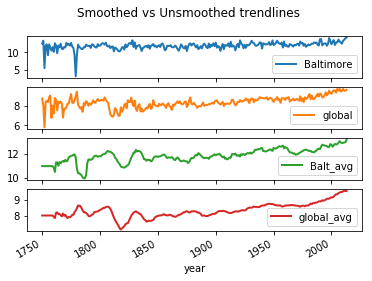

In [9]:
tidy.plot(subplots=True, lw=2, title='Smoothed vs Unsmoothed trendlines')
plt.show()

We can see, even just at a glance, that our moving average had the intended effect of 'smoothing' the data. We also see that, our outlier at 1778 has a pretty significant effect on the moving average. It seems that using a moving average can actually INCREASE the effect of an outlier. My prediction was completely wrong! In retrospect, this makes sense because that outlier was used in average calculations ten times rather than just in a single observation! We would have to think more about how to address this if we were going to proceed further with a real analysis.

They call it 'Exploratory Data Analysis' for a reason. The 'exploration' you do during data analysis will involve a lot of trial and error and making mistakes. This is why we love scripting languages and how easy they are to iterate on each time you need to revise your approach.

Now, lets look a little more closely at our 'smoothed' data.

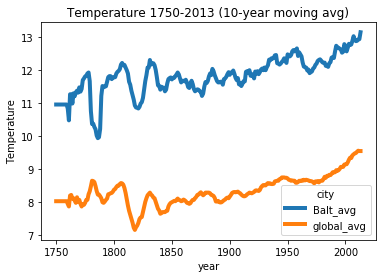

In [10]:
tidy[['Balt_avg','global_avg']].plot(lw=4, title='Temperature 1750-2013 \
(10-year moving avg)').set_ylabel('Temperature')
plt.show()

From this, we can observe the following: <br/>
1) The temperature in Baltimore has been significantly higher than the global average temperature for at least the past 250 years. This makes sense because Baltimore is relatively close to the equator. <br/>
2) Temperatures in Baltimore and in the world on average have been increasing. While this seems pretty clear, we can verify by plotting lines of best fit. 

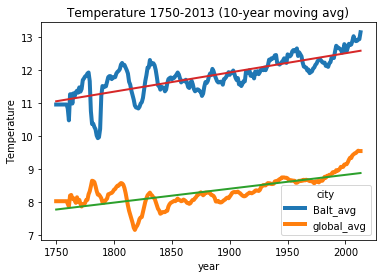

In [11]:
#Calculating the slope and y-intercept of each line of best fit. 
mbalt, bbalt = np.polyfit(tidy.index, tidy['Balt_avg'], 1) 
mglob, bglob = np.polyfit(tidy.index, tidy['global_avg'], 1)

#superimposing the linear regression onto the data plot
tidy[['Balt_avg','global_avg']].plot(lw=4, title='Temperature 1750-2013 \
(10-year moving avg)').set_ylabel('Temperature')
plt.plot(tidy.index, mglob*tidy.index+bglob, label='global', lw=2)
plt.plot(tidy.index, mbalt*tidy.index+bbalt, label='Baltimore', lw=2)
plt.show()

As this demonstrates, the temperature is trending upwards for both local and global data. This also brings us to:<br/>
3) The Baltimore line is steeper than the global line which means that avg temperature has been increasing more rapidly for Baltimore than it has for the world as a whole (at least during the years between 1750 and 2013) <br/>
4) The final (and perhaps most interesting, at least for someone who is interested in Baltimore!) observation is that, for the most part, the general trends of the temperatures in Baltimore closely matches that of the world, but about 3 degrees hotter. 